In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from tqdm import tqdm

# Paths
speech_dir = 'Audio_Speech_Actors_01-24'
song_dir = 'Audio_Song_Actors_01-24'


In [2]:
#map the files according to the labbeled emotion
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def parse_filename(file_path, modality):
    file_name = os.path.basename(file_path)
    parts = file_name.split('.')[0].split('-')
    
    return {
        'filename': file_name,
        'emotion_code': parts[2],
        'emotion': emotion_map.get(parts[2], 'unknown'),
        'intensity': 'normal' if parts[3] == '01' else 'strong',
        'actor': int(parts[-1]),
        'modality': modality,
        'path': file_path
    }


In [3]:
def collect_files(directory, modality):
    all_entries = []
    for actor_dir in os.listdir(directory):
        actor_path = os.path.join(directory, actor_dir)
        if os.path.isdir(actor_path):
            for file in os.listdir(actor_path):
                if file.endswith('.wav'):
                    file_path = os.path.join(actor_path, file)
                    entry = parse_filename(file_path, modality)
                    all_entries.append(entry)
    return all_entries

# Collect
speech_data = collect_files(speech_dir, 'speech')
song_data = collect_files(song_dir, 'song')

# Combine
df = pd.DataFrame(speech_data + song_data)
df.head()


,filename,emotion_code,emotion,intensity,actor,modality,path
0,03-01-01-01-01-01-01.wav,01,neutral,normal,1,speech,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...
1,03-01-01-01-01-02-01.wav,01,neutral,normal,1,speech,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...
2,03-01-01-01-02-01-01.wav,01,neutral,normal,1,speech,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...
3,03-01-01-01-02-02-01.wav,01,neutral,normal,1,speech,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...
4,03-01-02-01-01-01-01.wav,02,calm,normal,1,speech,Audio_Speech_Actors_01-24\Actor_01\03-01-02-01...


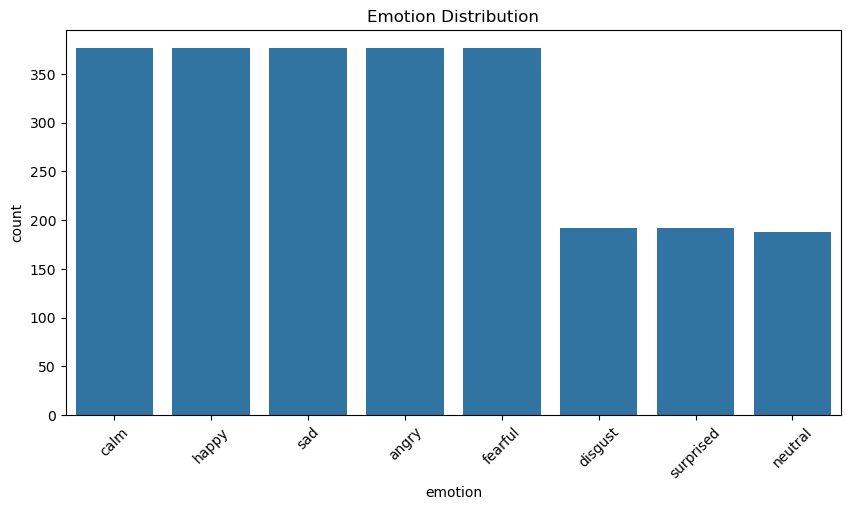

In [4]:
#emotion count distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='emotion', data=df, order=df['emotion'].value_counts().index)
plt.title("Emotion Distribution")
plt.xticks(rotation=45)
plt.show()


* Emotions calm, happy, sad, angry, and fearful are equally represented.

* Emotions like disgust, surprised, and neutral appear less frequently.

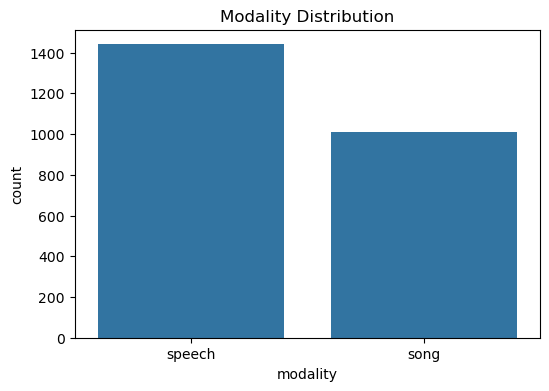

In [5]:
#data existence form
plt.figure(figsize=(6, 4))
sns.countplot(x='modality', data=df)
plt.title("Modality Distribution")
plt.show()


* More files in speech (around 1450) than song (around 1020).

* Reflects Actor 18 missing song data.

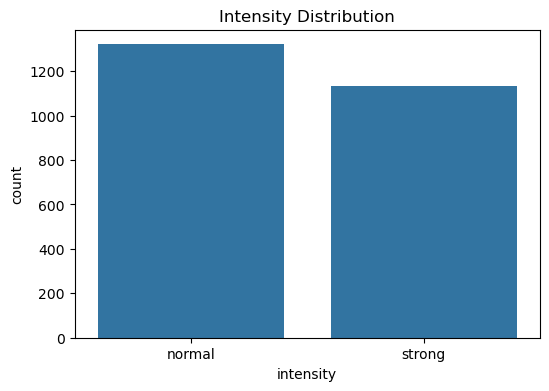

In [6]:
#intensity
plt.figure(figsize=(6, 4))
sns.countplot(x='intensity', data=df)
plt.title("Intensity Distribution")
plt.show()


* normal intensity is slightly more than strong.

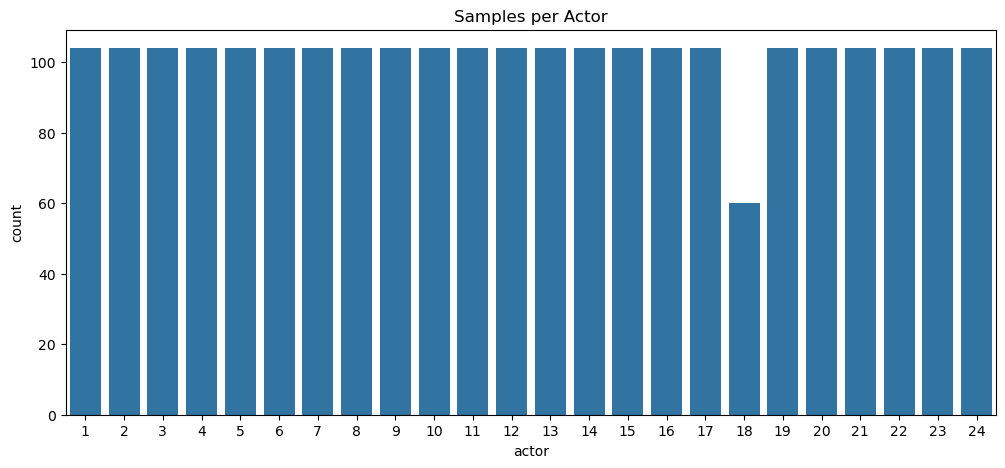

In [7]:
#actors and their sample counts
plt.figure(figsize=(12, 5))
sns.countplot(x='actor', data=df)
plt.title("Samples per Actor")
plt.show()


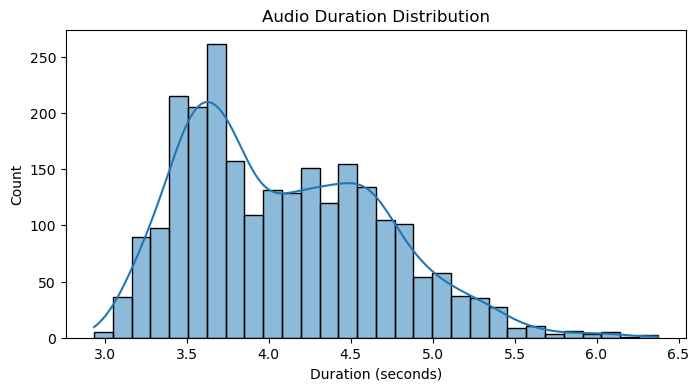

In [8]:
# audio duration analysis
def get_duration(row):
    try:
        y, sr = librosa.load(row['path'], sr=None)
        return librosa.get_duration(y=y, sr=sr)
    except:
        return None

df['duration'] = df.apply(get_duration, axis=1)

plt.figure(figsize=(8, 4))
sns.histplot(df['duration'].dropna(), bins=30, kde=True)
plt.title("Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.show()


* Most audio clips are between 3.5 to 4.5 seconds.

* Very few go above 6 seconds.

In [9]:
# Check for nulls
print("Null values:\n", df.isnull().sum())

# Drop rows with any null values (if needed)
df = df.dropna()

# Check for duplicates
print("\nDuplicates:", df.duplicated().sum())

# Drop duplicates
df = df.drop_duplicates()


Null values:
 filename        0
emotion_code    0
emotion         0
intensity       0
actor           0
modality        0
path            0
duration        0
dtype: int64

Duplicates: 0


In [10]:
#save the data frame ( for further use if needed )
df.to_csv('ravdess_metadata.csv', index=False)


In [11]:
#convert each audiofile to an image spectogram ( melspectogram )

# Output directory
output_dir = 'mel_spectrograms'
os.makedirs(output_dir, exist_ok=True)

#converter function
def audio_to_mel_image(audio_path, output_path, duration=4, sr=22050, img_size=(224, 224)):
    try:
        y, _ = librosa.load(audio_path, sr=sr, duration=duration)
        if len(y) < sr * duration:
            padding = sr * duration - len(y)
            y = np.pad(y, (0, int(padding)))

        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # Save mel spectrogram as image
        fig = plt.figure(figsize=(img_size[0] / 100, img_size[1] / 100), dpi=100)
        plt.axis('off')
        librosa.display.specshow(mel_db, sr=sr, cmap='viridis')
        fig.tight_layout(pad=0)
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")


In [12]:
# Process each file

for _, row in tqdm(df.iterrows(), total=len(df)):
    emotion = row['emotion']
    audio_path = row['path']
    filename = os.path.splitext(os.path.basename(audio_path))[0] + ".png"
    emotion_dir = os.path.join(output_dir, emotion)
    os.makedirs(emotion_dir, exist_ok=True)
    output_path = os.path.join(emotion_dir, filename)

    audio_to_mel_image(audio_path, output_path)
print("successful")

100%|██████████| 2452/2452 [01:24<00:00, 28.92it/s]

successful


In [13]:
#Confirm GPU is Enabled in PyTorch
import torch
print(torch.version.cuda)             
print(torch.cuda.is_available())      
print(torch.cuda.get_device_name(0))   

11.8
True
NVIDIA GeForce RTX 4060


In [14]:
#libraries and efficientnetb2 pretrained model
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, datasets
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torch.utils.data import DataLoader, random_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image


In [15]:
# Set gpu and parameters
BATCH_SIZE = 16
NUM_EPOCHS = 25
DATA_DIR = 'mel_spectrograms'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations
transform = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [16]:
# Custom loader to force RGB
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
dataset.loader = lambda path: Image.open(path).convert("RGB")

# Class info
NUM_CLASSES = len(dataset.classes)

# Split into train/validation sets 80:20
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)


In [17]:
# Compute class weights to balance undersampled classes
targets = [dataset.targets[i] for i in train_ds.indices]
weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
class_weights_tensor = torch.tensor(weights, dtype=torch.float).to(DEVICE)


In [18]:
#  set EfficientNet-B2
weights = EfficientNet_B2_Weights.DEFAULT
model = efficientnet_b2(weights=weights)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(DEVICE)


In [19]:
# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


In [20]:

# model Training Loop
train_losses, val_losses = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    #Validation
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            preds = torch.argmax(outputs, 1)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    accuracy = correct / len(val_ds)
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]  "
          f"Train Loss: {train_loss:.4f}  "
          f"Val Loss: {val_loss:.4f}  "
          f"Val Acc: {accuracy:.4f}")



Epoch [1/25]  Train Loss: 1.9841  Val Loss: 1.8152  Val Acc: 0.3198
Epoch [2/25]  Train Loss: 1.6669  Val Loss: 1.5446  Val Acc: 0.4521
Epoch [3/25]  Train Loss: 1.4176  Val Loss: 1.4003  Val Acc: 0.5356
Epoch [4/25]  Train Loss: 1.2351  Val Loss: 1.2988  Val Acc: 0.5784
Epoch [5/25]  Train Loss: 1.0986  Val Loss: 1.2478  Val Acc: 0.6130
Epoch [6/25]  Train Loss: 0.9861  Val Loss: 1.2052  Val Acc: 0.6354
Epoch [7/25]  Train Loss: 0.8899  Val Loss: 1.1644  Val Acc: 0.6782
Epoch [8/25]  Train Loss: 0.8250  Val Loss: 1.1530  Val Acc: 0.6782
Epoch [9/25]  Train Loss: 0.7491  Val Loss: 1.1380  Val Acc: 0.7088
Epoch [10/25]  Train Loss: 0.7153  Val Loss: 1.1050  Val Acc: 0.7251
Epoch [11/25]  Train Loss: 0.6885  Val Loss: 1.1041  Val Acc: 0.7352
Epoch [12/25]  Train Loss: 0.6763  Val Loss: 1.1176  Val Acc: 0.7312
Epoch [13/25]  Train Loss: 0.6603  Val Loss: 1.1016  Val Acc: 0.7352
Epoch [14/25]  Train Loss: 0.6405  Val Loss: 1.1019  Val Acc: 0.7251
Epoch [15/25]  Train Loss: 0.6181  Val Loss

In [21]:
#  Final Evaluation
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [22]:
# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=dataset.classes))



Classification Report:

              precision    recall  f1-score   support

       angry       0.87      0.87      0.87        69
        calm       0.76      0.89      0.82        61
     disgust       0.72      0.83      0.77        35
     fearful       0.67      0.87      0.76        79
       happy       0.85      0.71      0.77        95
     neutral       0.67      0.79      0.72        43
         sad       0.77      0.47      0.59        76
   surprised       0.84      0.79      0.81        33

    accuracy                           0.76       491
   macro avg       0.77      0.78      0.76       491
weighted avg       0.77      0.76      0.76       491



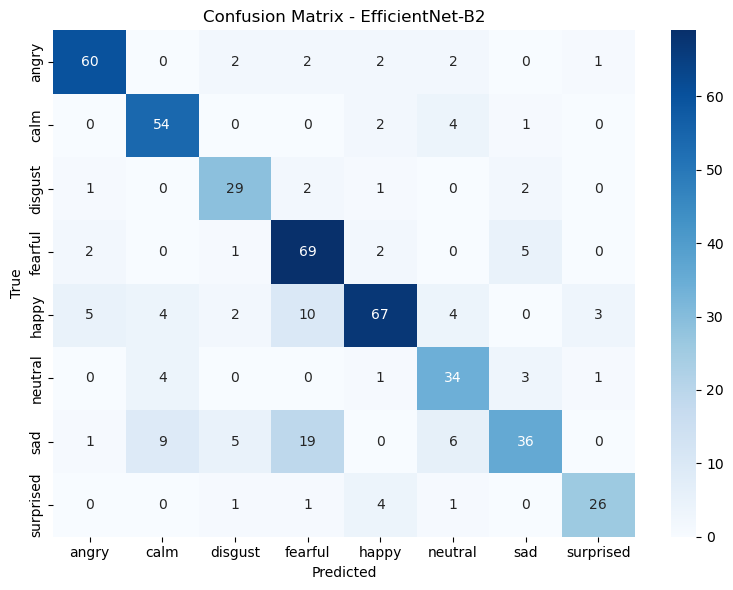

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=dataset.classes, yticklabels=dataset.classes, cmap='Blues')
plt.title("Confusion Matrix - EfficientNet-B2")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [24]:
# save the model
torch.save(model.state_dict(), 'efficientnet_b2_emotion.pth')
